# Spotify Clustering Analysis-MSCA 31008 5 (Winter 2022) Data Mining Principles

Resources:

https://towardsdatascience.com/k-means-clustering-using-spotify-song-features-9eb7d53d105c

## The goal of this notebook is two-fold: 

### Provide insights into commonalities between popular songs accross the globe to better understand what makes a 'popular' song

### Provide clusters based on feature analysis, which can be used to inform popularity classification modeling

## Import required packages 

In [1]:
import pandas as pd
from itertools import permutations
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import plotly.express as px
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.filterwarnings('ignore')

## Read-in Spotify dataframe, selecting only the columns of interest for feature analysis 

In [2]:
df = pd.read_csv("combined_playlist.csv")

columns = ["Length", "Acousticness", "Danceability", "Energy","Instrumentalness","Liveness",'Loudness' , "Speechiness", "Tempo", "Valence"]
df = df[columns]
df.head()

Length  Acousticness  Danceability  Energy  Instrumentalness  Liveness  \
0  242013        0.7210         0.585   0.436          0.000013    0.1050   
1  198081        0.3210         0.677   0.696          0.000000    0.4200   
2  238805        0.4400         0.761   0.525          0.000007    0.0921   
3  298899        0.7670         0.332   0.225          0.003490    0.1280   
4  141805        0.0383         0.591   0.764          0.000000    0.1030   

   Loudness  Speechiness    Tempo  Valence  
0    -8.761       0.0601  143.874    0.132  
1    -6.181       0.1190   90.030    0.464  
2    -6.900       0.0944   80.870    0.531  
3    -8.697       0.0348   81.055    0.297  
4    -5.484       0.0483  169.928    0.478

## Scale the data for better feature analysis

In [3]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled1 = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled1)
df_scaled.columns = ["Length", "Acousticness", "Danceability", "Energy","Instrumentalness","Liveness",'Loudness' , "Speechiness", "Tempo", "Valence"]

## Heat map for feature analysis. Features with some correlation include energy/loudness, and danceability/valence, however there are not too many correlations that yield high scores.

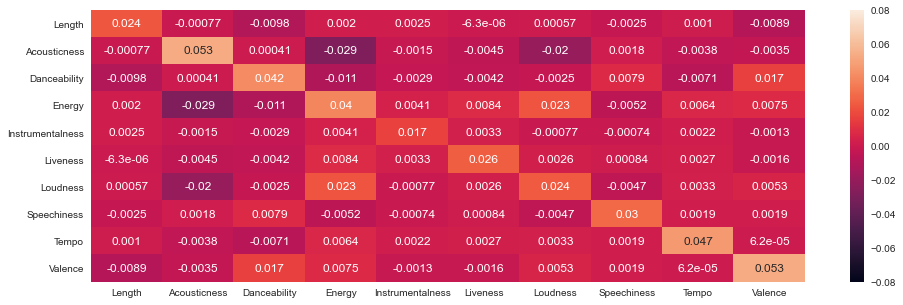

In [4]:
plt.figure(figsize = (16,5))
ax = sns.heatmap(df_scaled.cov(),vmin=-0.08, vmax=0.08, annot = True)
plt.show()

## Violin plot for feature analysis. We can extract the following insights from this plot:

### Popular songs tend to have low levels of acousticness, instrumenalness, and speechiness.

### Popular songs tend to be on the louder side, with a good number of songs having high danceability and energy levels 

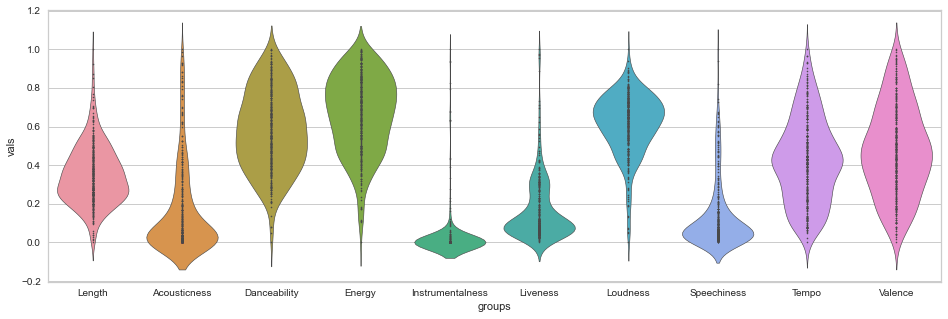

In [5]:
dfMelt = df_scaled.melt(var_name='groups', value_name='vals')
plt.figure(figsize = (16,5))
ax = sns.violinplot(x="groups", y="vals", data=dfMelt, linewidth = 0.6, inner = 'point', scale= 'width')
plt.show()

## Establish table to capture KMeans Scoring Output

In [6]:
perm = permutations(columns, 3)
output = set(map(lambda x: tuple(sorted(x)),perm))
a=[]
column_names = ["features", "score", "elbow"]
# Setting up df to hold scoring outputs 
df3 = pd.DataFrame(columns = column_names)

## Function Scoring and Outputting KMeans Scoring to find optimal variables for clustering

                                          features     score elbow
0                    [Acousticness, Energy, Tempo]  0.420310     2
1          [Instrumentalness, Length, Speechiness]  0.565502     3
2         [Instrumentalness, Speechiness, Valence]  0.460822     4
3                  [Energy, Loudness, Speechiness]  0.451688     3
4         [Acousticness, Instrumentalness, Length]  0.544352     3
5              [Instrumentalness, Length, Valence]  0.402504     3
6           [Instrumentalness, Speechiness, Tempo]  0.441193     4
7           [Acousticness, Danceability, Loudness]  0.437454     2
8            [Acousticness, Loudness, Speechiness]  0.504878     2
9                  [Length, Liveness, Speechiness]  0.473790     2
10       [Acousticness, Danceability, Speechiness]  0.417141     2
11              [Acousticness, Liveness, Loudness]  0.494810     2
12                 [Acousticness, Loudness, Tempo]  0.441169     2
13        [Acousticness, Energy, Instrumentalness]  0.521391  

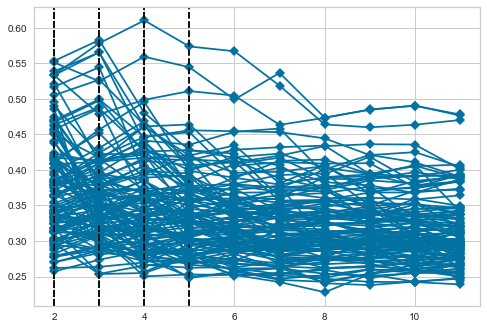

In [7]:
for i in list(output):
    df1 = df[[i[0], i[1], i[2]]]
    x = df1.values  # returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    model = KMeans(random_state=0)
    visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette', timings=False)
    visualizer.fit(x_scaled)
    score = visualizer.elbow_score_
    value = visualizer.elbow_value_
    if score>0.4:
        # visualizer.show()
        idx = df1.columns
        mylist = idx.tolist()
        dict = {
            "features": mylist,
            "score": score,
            "elbow": value
        }
        df3 = df3.append(dict, ignore_index=True)

print(df3)

# Identify KMeans Components w/ highest scores to select variables of interest for clustering 

In [8]:
df3.nlargest(10,['score'])

features     score elbow
17  [Acousticness, Instrumentalness, Speechiness]  0.610173     4
27     [Acousticness, Instrumentalness, Loudness]  0.582532     3
1         [Instrumentalness, Length, Speechiness]  0.565502     3
37      [Instrumentalness, Loudness, Speechiness]  0.565064     3
38      [Instrumentalness, Liveness, Speechiness]  0.551032     2
4        [Acousticness, Instrumentalness, Length]  0.544352     3
15     [Acousticness, Instrumentalness, Liveness]  0.533139     2
13       [Acousticness, Energy, Instrumentalness]  0.521391     2
8           [Acousticness, Loudness, Speechiness]  0.504878     2
16          [Acousticness, Liveness, Speechiness]  0.499107     3

## Function outputing KMeans 3-D Clustering and violin plot displaying feature analysis for the top 3 unique clusters 

In [9]:
def cluster_output(clusters, elem1, elem2, elem3):
    df1 = df[[elem1, elem2, elem3]]

    x = df1.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled2 = min_max_scaler.fit_transform(x)
    df1 = pd.DataFrame(x_scaled2)
    
    kmeans = KMeans(init="k-means++",
                n_clusters=clusters,
                random_state=15,
                max_iter = 500).fit(x_scaled2)
    df1['kmeans'] = kmeans.labels_
    df1.columns = [elem1, elem2, elem3, 'kmeans' ]


    kmeans = df1['kmeans']
    df1['kmeans'] = kmeans

    fig = px.scatter_3d(df1, x=elem1, y=elem2, z=elem3,
                  color='kmeans')
    fig.show()
    
    c0 = df1[df1['kmeans']==0]
    c1 = df1[df1['kmeans']==1]
    c2 = df1[df1['kmeans']==2]

    c0.drop(['kmeans'], axis=1, inplace=True)
    c1.drop(['kmeans'], axis=1, inplace=True)
    c2.drop(['kmeans'], axis=1, inplace=True)

    x = c0.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    c0_scaled = min_max_scaler.fit_transform(x)
    c0 = pd.DataFrame(c0_scaled)
    c0.columns = [elem1, elem2, elem3]
    c0=c0.melt(var_name='groups', value_name='vals')

    x = c1.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    c1_scaled = min_max_scaler.fit_transform(x)
    c1 = pd.DataFrame(c1_scaled)
    c1.columns = [elem1, elem2, elem3]
    c1=c1.melt(var_name='groups', value_name='vals')

    x = c2.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    c2_scaled = min_max_scaler.fit_transform(x)
    c2 = pd.DataFrame(c2_scaled)
    c2.columns = [elem1, elem2, elem3]
    c2=c2.melt(var_name='groups', value_name='vals')

    f, axes = plt.subplots(3, 1)
    ax = sns.violinplot( data=c0 ,x="groups", y="vals", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[0])
    ax = sns.violinplot( data=c1 ,x="groups", y="vals", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[1])
    ax = sns.violinplot( data=c2 ,x="groups", y="vals", linewidth = 0.6, inner = 'point', scale= 'width', ax=axes[2])

    plt.show()

## Popularity Analysis: ID:48 [Acousticness, Instrumentalness, Speechiness] with score 0.610173 and 4 clusters. 

## We see that the two most populated clusters have very low instrumental levels and relatively low speechiness. Clusters 1 and 3 have low acoustic levels. This would indicate that popular songs are have less instrumentals and speechiness.

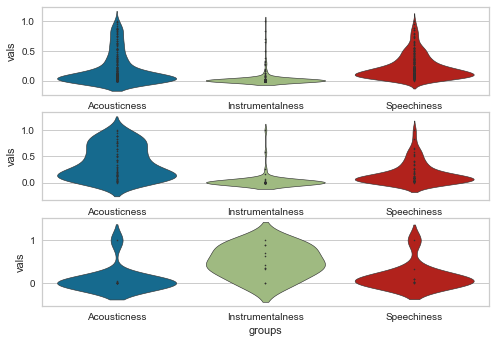

In [10]:
cluster_output(4, 'Acousticness', 'Instrumentalness', 'Speechiness')

## Popularity Analysis: ID:16 [Instrumentalness, Length, Speechiness] with score 0.565502 and 3 clusters

## These cluster groupings show us that the length of songs appears to be evenly distributed accross all three clusters. This would indicate that song length may not be largely correlated with popularity  

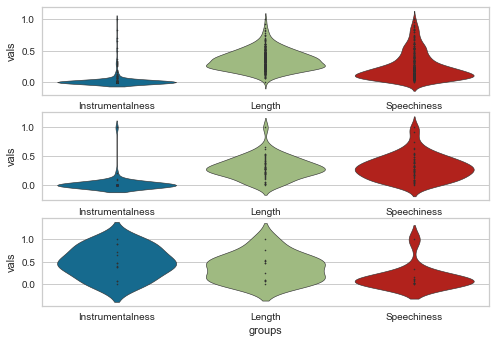

In [11]:
cluster_output(3, 'Instrumentalness', 'Length', 'Speechiness')

## Popularity Analysis: ID:53 [Acousticness, Instrumentalness, Loudness] with score 0.582532 and 3 clusters

## All three clusters appear to have larger loudness score, indicating there may be a correlation between popularity and loudness 

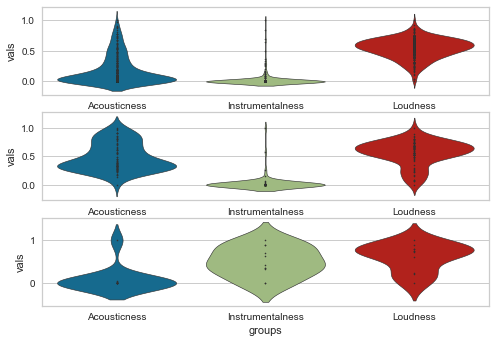

In [12]:
cluster_output(3, 'Acousticness', 'Instrumentalness', 'Loudness')

## Add unique clusters to original dataframe to conduct further modeling analysis

In [13]:
def cluster_labels(clusters, elem1, elem2, elem3, kname):
    df1 = df[[elem1, elem2, elem3]]

    x = df1.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled2 = min_max_scaler.fit_transform(x)
    df1 = pd.DataFrame(x_scaled2)
    
    kmeans = KMeans(init="k-means++",
                n_clusters=clusters,
                random_state=15,
                max_iter = 500).fit(x_scaled2)
    df1['kmeans'] = kmeans.labels_
    df1.columns = [elem1, elem2, elem3, 'kmeans' ]


    kmeans = df1['kmeans']
    df[kname] = kmeans

In [14]:
cluster_labels(4, 'Acousticness', 'Instrumentalness', 'Speechiness', 'clust1')

In [15]:
cluster_labels(3, 'Instrumentalness', 'Length', 'Speechiness', 'clust2')

In [16]:
cluster_labels(3, 'Acousticness', 'Instrumentalness', 'Loudness', 'clust3')

In [17]:
df.head()

Length  Acousticness  Danceability  Energy  Instrumentalness  Liveness  \
0  242013        0.7210         0.585   0.436          0.000013    0.1050   
1  198081        0.3210         0.677   0.696          0.000000    0.4200   
2  238805        0.4400         0.761   0.525          0.000007    0.0921   
3  298899        0.7670         0.332   0.225          0.003490    0.1280   
4  141805        0.0383         0.591   0.764          0.000000    0.1030   

   Loudness  Speechiness    Tempo  Valence  clust1  clust2  clust3  
0    -8.761       0.0601  143.874    0.132       1       0       1  
1    -6.181       0.1190   90.030    0.464       1       0       1  
2    -6.900       0.0944   80.870    0.531       1       0       1  
3    -8.697       0.0348   81.055    0.297       1       0       1  
4    -5.484       0.0483  169.928    0.478       0       0       0

## Review cluster segmentations. Clusters appear to be unbalanced, which may need to be addressed in modeling 

In [18]:
df['clust1'].value_counts()

0    271
1     69
3     45
2     11
Name: clust1, dtype: int64

In [19]:
df['clust2'].value_counts()

0    327
1     56
2     13
Name: clust2, dtype: int64

In [20]:
df['clust3'].value_counts()

0    305
1     80
2     11
Name: clust3, dtype: int64

In [21]:
#df.to_csv(r"C:\Users\Nick's Laptop\Desktop\Data Mining Principles\spotifyProject\spotifyClusters.csv", sep=',')

## Additional visual analysis: tSne and hierarchical clustering 

In [22]:
# Extract songs that are associated witht the top-30 most popular genres 
genre_df_init = pd.read_csv("combined_playlist.csv")
top50 = genre_df_init['Top_Genre'].value_counts().index[:50]
genre_df_init = genre_df_init[genre_df_init['Top_Genre'].isin(top50)]

# Get averages for each feature column to generalize genre features 
grouped_df = genre_df_init.groupby("Top_Genre")
mean_df = grouped_df.mean()
genre_df = mean_df.reset_index()

In [23]:
# Select features of interest
x=genre_df[genre_df.columns[6:16]]
genre_df["Top_Genre"].fillna('None Given', inplace = True)
genres=genre_df['Top_Genre'].values

# extract values from dataset
elems=x.values

# Normalize the delta values: normalized_delta
normalized_elems = normalize(elems)

## Applying tSne to the top 50 genres within the dataset, we can see a few components of interest:

### One primary cluster includes modern rock/metal genres

### We see emd and several pop alternatives clustered together 

### There are several genres that are isolated, like new orleans jazz and gen-z singer/songwriter

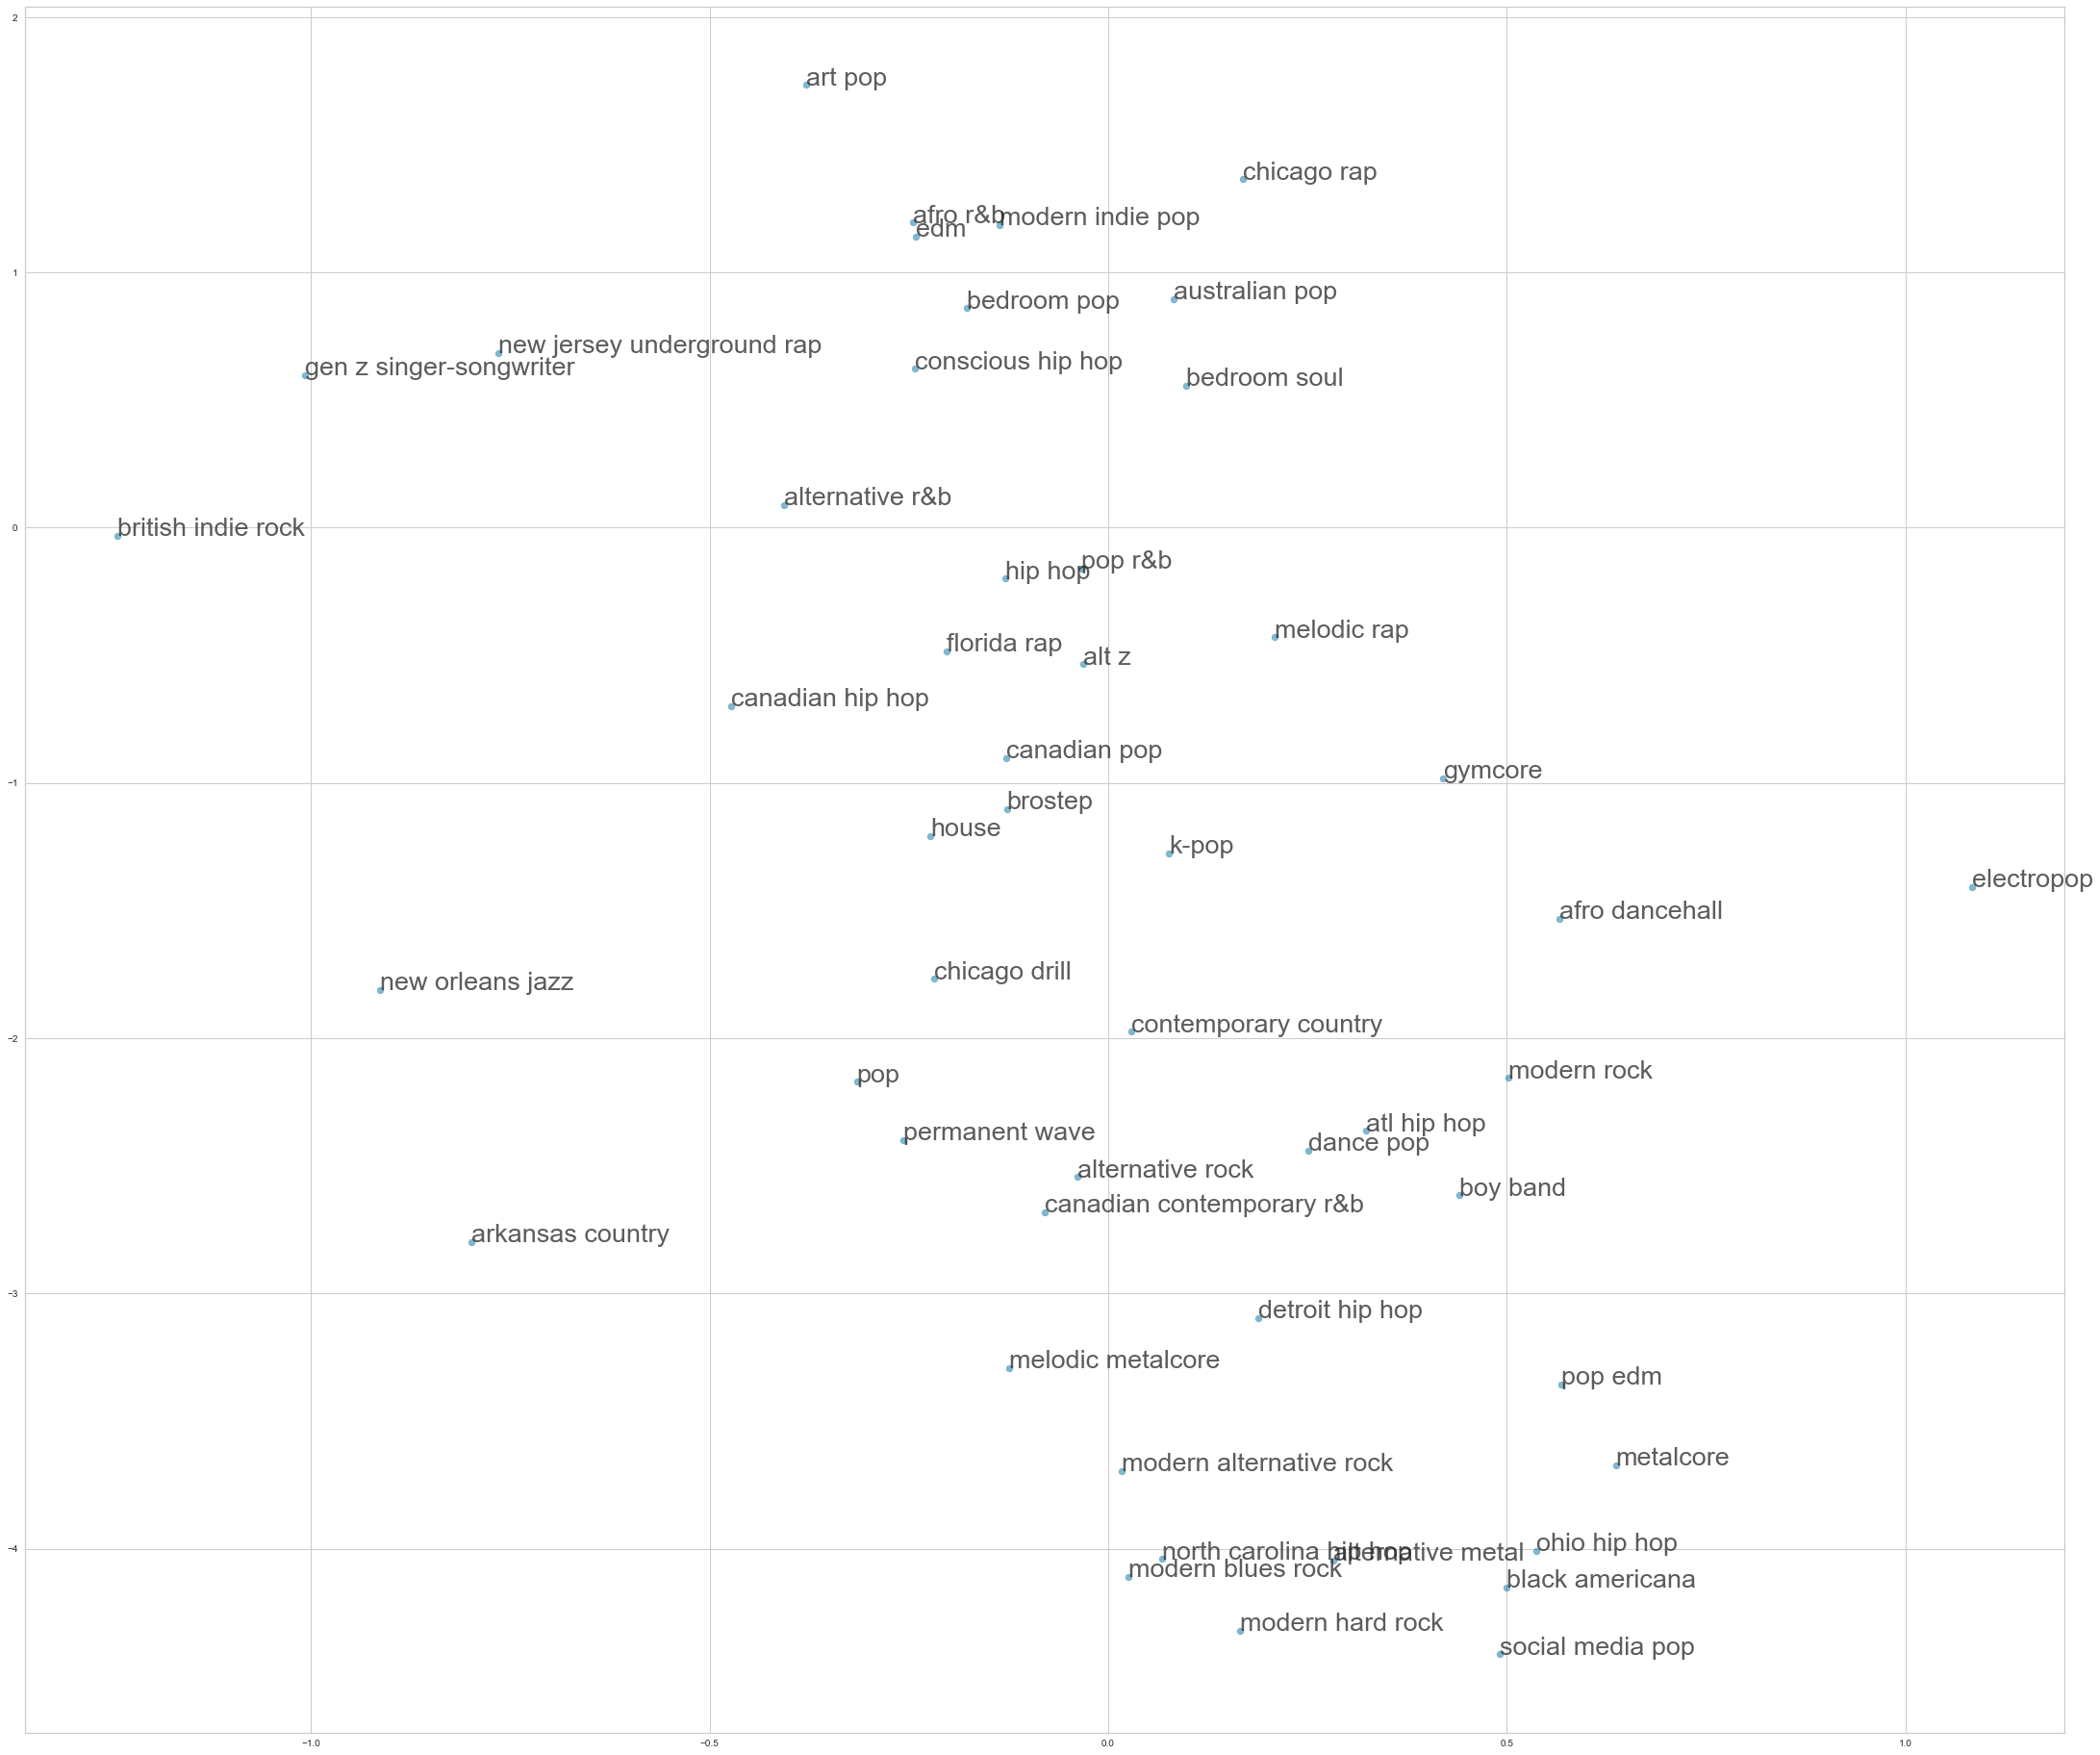

In [24]:
plt.figure(figsize=(38,33))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_elems)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1th feature: ys
ys = tsne_features[:,1]

# Scatter plot
plt.scatter(xs, ys, alpha=0.5)
# Annotate the points
for x, y, genre in zip(xs, ys, genres):
    plt.annotate(genre, (x, y), fontsize=27, alpha=0.75)
plt.show()

## Applying hierarchical clustering via a dendogram provides similar results to tSne:

### Rock and metal genres make up one primary cluster, while rap and hip-hop make up another. Pop appears to be scattered equally between the two. 

### The cluster identified in the tSne plot containing edm and several pop sub-genres remains relatively isolated in the dendogram for multiple merges 

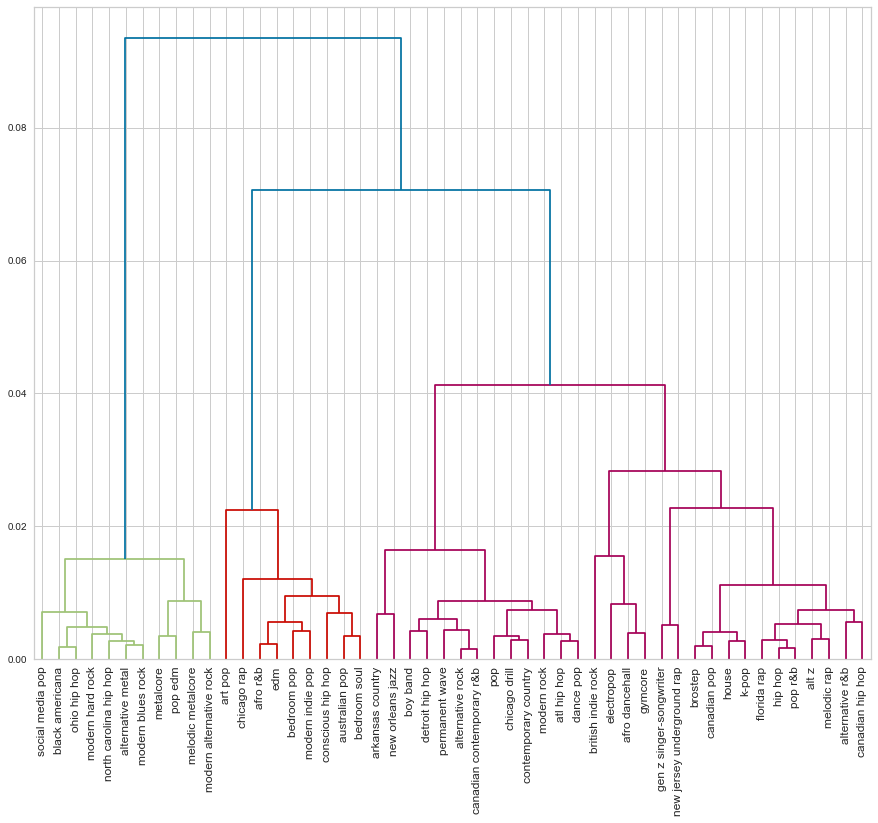

In [25]:
plt.figure(figsize=(15,12))

# Calculate the linkage: mergings
mergings = linkage(normalized_elems, method='ward')

# Plot the dendrogram
dendrogram(
    mergings,
    labels=genres,
    leaf_rotation=90.,
    leaf_font_size=12
)


#"Your code here"
plt.show()